## IMPORTS

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns   # plotting heatmap
torch.manual_seed(1)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from sklearn.model_selection import train_test_split

## IMPORT DATA

In [12]:
df_train = pd.read_csv("datasets/ptbdb_train.csv",header=None)
df_test = pd.read_csv("datasets/ptbdb_test.csv",header=None)

## LSTM

In [13]:
X_train, y_train = [], [] 
X_train = df_train.iloc[:,:-1].values
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = df_train.iloc[:,-1].values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)

X_test, y_test = [], []
X_test = df_test.iloc[:,:-1].values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = df_test.iloc[:,-1].values


In [14]:
LAYERS = [10, 10, 10,10, 1]                # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
T = X_train.shape[1]
BATCH = 256                          # batch size
EPOCH = 50                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

layers=[10, 10, 10, 10, 1], train_examples=9894, test_examples=2911
batch = 256, features = 1, epochs = 50
lr = 0.05, lambda = 0.03, dropout = 0.0, recurr_dropout = 0.0


In [15]:
# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[3],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(Dense(units=LAYERS[4], activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data = (X_val, y_val),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)


/home/ilboglions/anaconda3/envs/MLHC/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 187, 10)        │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 187, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 187, 10)        │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 187, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 187, 10)        │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 187, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,171 (12.39 KB)

 Trainable params: 3,091 (12.07 KB)

 Non-trainable params: 80 (320.00 B)

None
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6752 - loss: 1.4514 - val_accuracy: 0.7224 - val_loss: 0.6220 - learning_rate: 0.0500
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 362ms/step - accuracy: 0.7260 - loss: 0.6023 - val_accuracy: 0.7224 - val_loss: 0.5914 - learning_rate: 0.0500
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 338ms/step - accuracy: 0.7253 - loss: 0.5886 - val_accuracy: 0.7224 - val_loss: 0.5925 - learning_rate: 0.0500
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 344ms/step - accuracy: 0.7272 - loss: 0.5865 - val_accuracy: 0.7224 - val_loss: 0.5907 - learning_rate: 0.0500
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 346ms/step - accuracy: 0.7202 - loss: 0.5937 - val_accuracy: 0.7224 - val_loss: 0.5913 - learning_rate: 0.0500
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 338ms/step - accuracy: 0.7228 - loss: 0.5906 - val_accuracy: 0.7224 - val_loss: 0.5916 - learning_rate: 0.0250
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 333ms/step - accuracy: 0.7204 - los

-----------------------------------------------------------------
train accuracy = 72.1852%
test accuracy = 72.2089%
test error = 809 out of 2911 examples


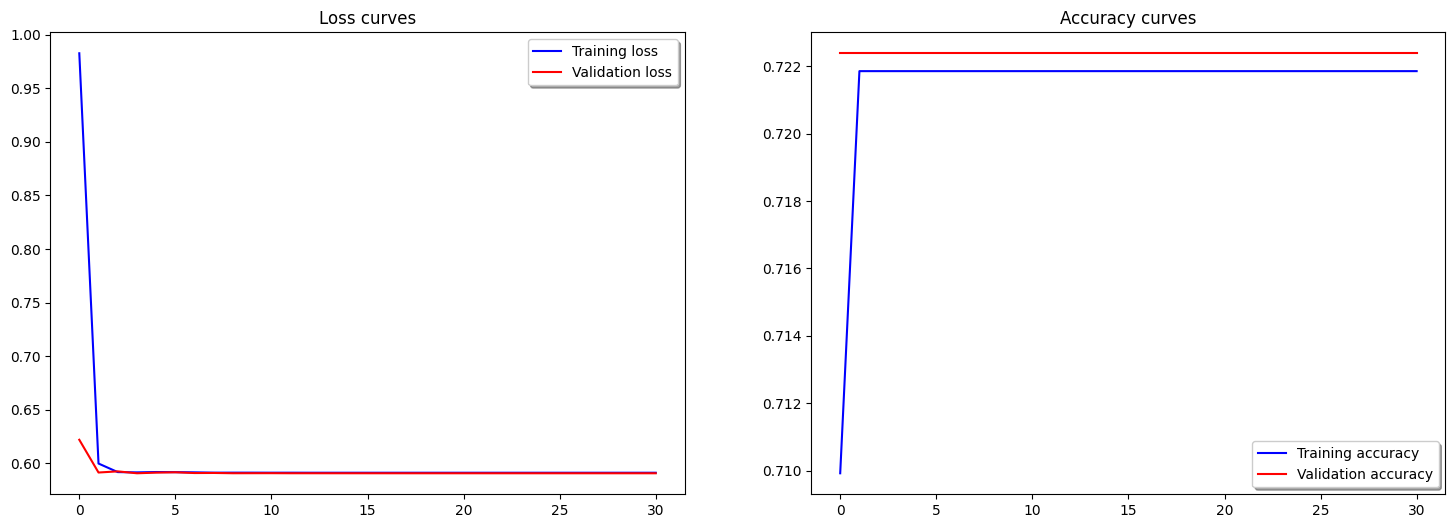

In [16]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [18]:
bidirectional_model = Sequential()
bidirectional_model.add(Bidirectional(LSTM(units=LAYERS[0],
                             activation='tanh', recurrent_activation='hard_sigmoid',
                             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                             dropout=DP, recurrent_dropout=RDP,
                             return_sequences=True, return_state=False,
                             stateful=False, unroll=False
                            ), input_shape=(T, N)))
bidirectional_model.add(BatchNormalization())
bidirectional_model.add(Bidirectional(LSTM(units=LAYERS[1],
                             activation='tanh', recurrent_activation='hard_sigmoid',
                             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                             dropout=DP, recurrent_dropout=RDP,
                             return_sequences=True, return_state=False,
                             stateful=False, unroll=False
                            )))
bidirectional_model.add(BatchNormalization())
bidirectional_model.add(Bidirectional(LSTM(units=LAYERS[2],
                             activation='tanh', recurrent_activation='hard_sigmoid',
                             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                             dropout=DP, recurrent_dropout=RDP,
                             return_sequences=True, return_state=False,
                             stateful=False, unroll=False
                            )))
bidirectional_model.add(BatchNormalization())
bidirectional_model.add(Bidirectional(LSTM(units=LAYERS[3],
                             activation='tanh', recurrent_activation='hard_sigmoid',
                             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                             dropout=DP, recurrent_dropout=RDP,
                             return_sequences=False, return_state=False,
                             stateful=False, unroll=False
                            )))
bidirectional_model.add(BatchNormalization())
bidirectional_model.add(Dense(units=LAYERS[4], activation='sigmoid'))

# Compile the model with Adam optimizer
bidirectional_model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(learning_rate=LR))
print(bidirectional_model.summary())
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = bidirectional_model.fit(X_train, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_data=(X_val, y_val),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 187, 20)        │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 187, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 187, 20)        │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 187, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 187, 20)        │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 187, 20)        │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 20)             │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,741 (34.14 KB)

 Trainable params: 8,581 (33.52 KB)

 Non-trainable params: 160 (640.00 B)

None
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - accuracy: 0.6778 - loss: 3.3441 - val_accuracy: 0.7224 - val_loss: 0.8562 - learning_rate: 0.0500
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 421ms/step - accuracy: 0.7204 - loss: 0.6986 - val_accuracy: 0.7224 - val_loss: 0.6587 - learning_rate: 0.0500
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step - accuracy: 0.7213 - loss: 0.5889 - val_accuracy: 0.7224 - val_loss: 0.6528 - learning_rate: 0.0500
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.7167 - loss: 0.5933 - val_accuracy: 0.7224 - val_loss: 0.6356 - learning_rate: 0.0500
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step - accuracy: 0.7183 - loss: 0.7272 - val_accuracy: 0.7224 - val_loss: 0.6894 - learning_rate: 0.0500
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 407ms/step - accuracy: 0.7306 - loss: 0.5635 - val_accuracy: 0.7224 - val_loss: 0.6951 - learning_rate: 0.0250
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step - accuracy: 0.7423 - los

-----------------------------------------------------------------
train accuracy = 86.0623%
test accuracy = 85.8468%
test error = 412 out of 2911 examples


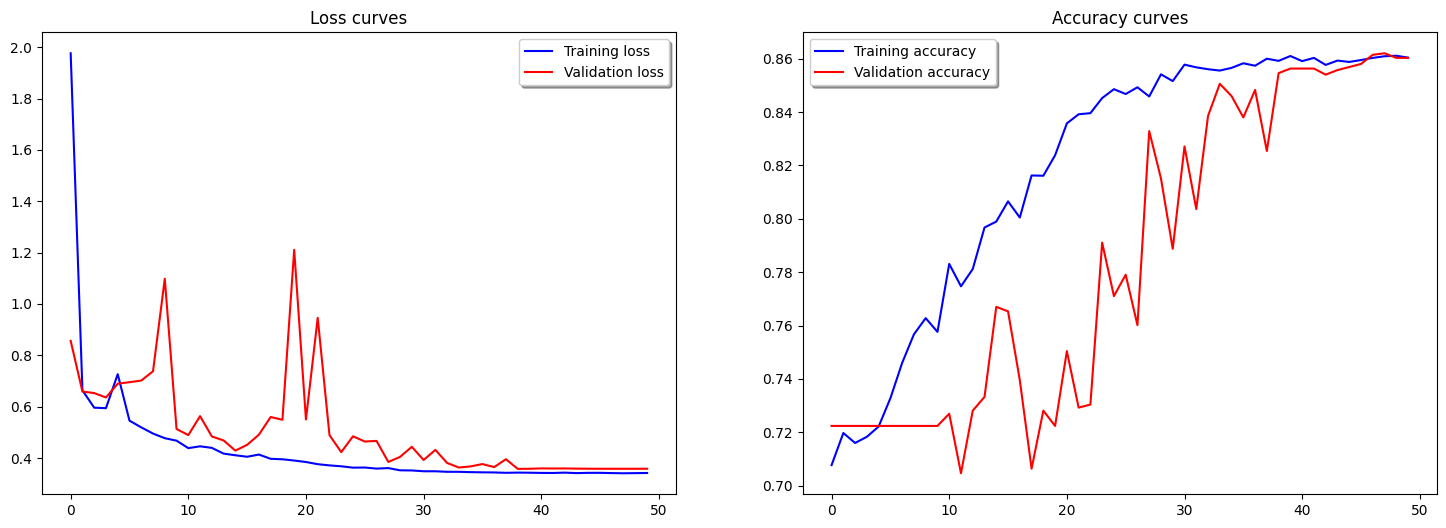

In [20]:
# Evaluate the model:
train_loss, train_acc =  bidirectional_model.evaluate(X_train, y_train,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = bidirectional_model.evaluate(X_test[:M_TEST], y_test[:M_TEST],
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()